# Fourier Transformation

In [14]:
import numpy as np
import dft
import utils

## Naive DFT

### 이미지 전체에 대해서

In [3]:
naive_dft = dft.NaiveDFT("./Boneyard_IMG_5341.jpg")

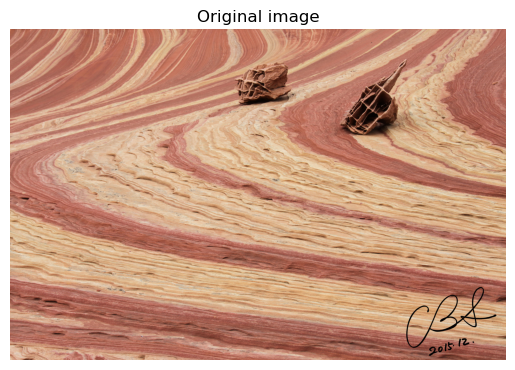

(3598, 5397, 3)

In [7]:
# original image
naive_dft.imshow(True)
naive_dft.image.shape

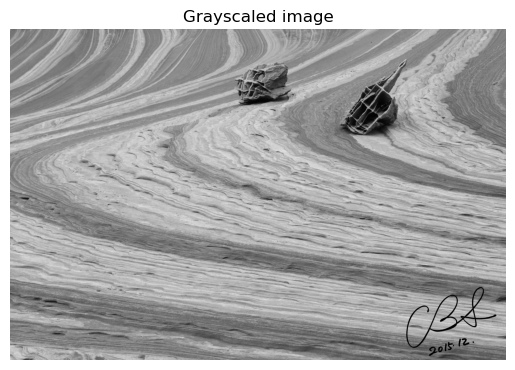

In [5]:
# grayscaled image
naive_dft.imshow(False)

In [ ]:
# impractical (예상시간 : 4년)
# naive_dft.dft2d()

### 이미지 일부에 대해서

In [12]:
image = utils.load_image("./Boneyard_IMG_5341.jpg")
image_fraction = image[25:75, 25:75]
naive_dft2 = dft.NaiveDFT(image_fraction)
naive_dft2.image.shape

(50, 50, 3)

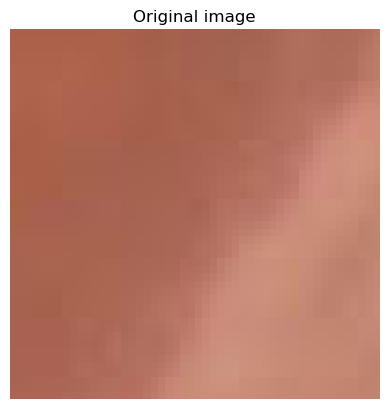

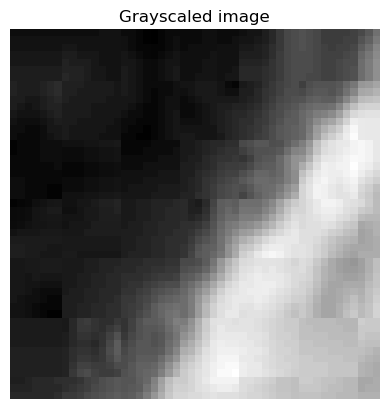

In [13]:
naive_dft2.imshow(True)
naive_dft2.imshow(False)

In [17]:
# validation
naive_dft2.dft2d()
dft_by_numpy = np.fft.fft2(naive_dft2.image_grayscaled)
dft_by_naivedft2 = naive_dft2.dft2d_array
abs(np.max(dft_by_numpy - dft_by_naivedft2))

2500it [00:03, 667.78it/s]


1.5882368629724538e-09

## Vectorized DFT

In [18]:
vector_dft = dft.VectorizedDFT(image)
vector_dft2 = dft.VectorizedDFT(image_fraction)

### 이미지 일부에 대해서

In [20]:
# 4중 for loop 모두 제거한 버전
vector_dft2.dft2d_vecvec()
abs(np.max(dft_by_numpy - vector_dft2.dft2d_array))

1.2407488133845234e-09

In [21]:
# 2중 for loop 하나 제거한 버전
vector_dft2.dft2d_vec()
abs(np.max(dft_by_numpy - vector_dft2.dft2d_array))

2500it [00:00, 30028.64it/s]


6.203579374302437e-10

### 이미지 전체에 대해서

In [29]:
# 4중 for loop 모두 제거한 버전 : impractical (out of memory)
vector_dft.dft2d_vecvec()

MemoryError: Unable to allocate 5.36 PiB for an array with shape (3598, 3598, 5397, 5397) and data type complex128

In [30]:
# 2중 for loop 하나 제거한 버전 : 다소 오래걸림 (전체 약 3600 * 5400 it)
vector_dft.dft2d_vec()

75it [00:09,  7.65it/s]


KeyboardInterrupt: 

# Haar Wavelet

In [1]:
import numpy as np
import utils
from typing import Union
from skimage.transform import resize

In [2]:
class Load_Image:
    def __init__(self, image_or_path: Union[np.ndarray, str]) -> None:
        if isinstance(image_or_path, np.ndarray):
            self.image = image_or_path
        elif isinstance(image_or_path, str):
            self.image = utils.load_image(image_or_path)
        else:
            raise TypeError("Invalid type : image_or_path")
        
        try:
            self.image_grayscaled = utils.grayscaling(self.image)
        except AssertionError:
            self.image_grayscaled = self.image
    
    def imshow(self, original: bool = True):
        if original:
            utils.imshow(self.image, "Original image", False)
        else:
            utils.imshow(self.image_grayscaled, "Grayscaled image", True)

    #not actually used (would be cheating since skimage was used... but just for testing purposes (scale down, and see O graph))        
    def resize(self, size: tuple):
        #only resizes grayscaled image
        self.image_grayscaled = resize(self.image_grayscaled, size)
    
    def pad(self,size: tuple):
        #only pads grayscaled image
        #used to pad with zeros (0) so that the image size is a power of 2 #size : (row, col)
        row, col = self.image_grayscaled.shape
        assert row <= size[0] and col <= size[1], "Invalid size : size must be larger than the original image"
        row_pad = size[0] - row
        col_pad = size[1] - col
        self.image_grayscaled = np.pad(self.image_grayscaled, ((0,row_pad),(0,col_pad)), 'constant', constant_values=0)


(3598, 5397)
(3598, 5397, 3)
(128, 128)


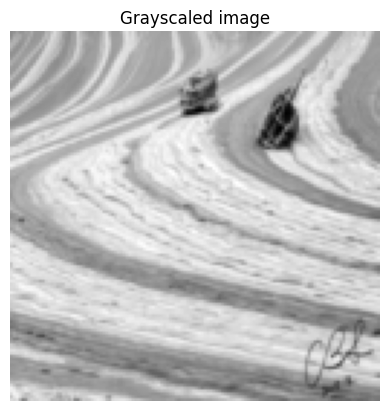

In [3]:
print(Load_Image("./Boneyard_IMG_5341.jpg").image_grayscaled.shape)
#HaarTransform("./Boneyard_IMG_5341.jpg").imshow(False)

a = Load_Image("./Boneyard_IMG_5341.jpg")
a.resize((128, 128))
print(a.image.shape)

print(a.image_grayscaled.shape) #does not resize this!
a.imshow(False)


(3598, 5397, 3)
(8192, 8192)


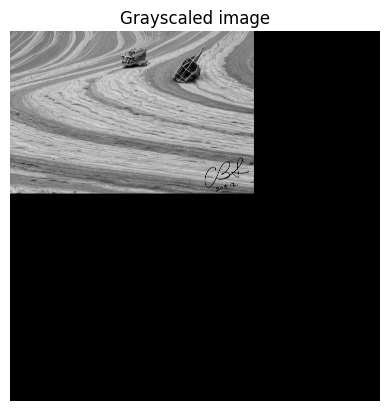

In [4]:
a = Load_Image("./Boneyard_IMG_5341.jpg")
a.pad((8192, 8192))
print(a.image.shape)

print(a.image_grayscaled.shape) #does not resize this!
a.imshow(False)


### Haar wavelet construction : use the equation below taught during class


**주의** 
밑의 n은 $2**n$할때 그 n이다. 따라서 밑의 n과는 다르다! (`get_haar_mat`에서 그래서 log취해서 함)

![Alt text](IMG_E49B43BAD0E8-1.jpeg)

### really implement

In [14]:
class HaarTransform(Load_Image):
    def __init__(self, image_or_path: Union[np.ndarray, str]) -> None:
        super().__init__(image_or_path)

    def n_to_size(self, n: int) -> int:
        return 2 ** n

    def get_haar_mat(self,size: int) -> np.ndarray:
        # only allow n of power of 2 and n > 0 (check with bitwise and operator)
        assert size & (size - 1) == 0 and size >= 0, "n must be a zero or positive power of 2"
        #get n in the equation (cause 2^n = size)
        n = int(np.log2(size))

        # base case
        if n == 0:
            return np.array([[1]])
        else : 
            # recursive case, use np.kron to get kronecker product
            left_mat = np.kron(self.get_haar_mat(self.n_to_size(n - 1)), np.array([[1], [1]])) #reason for [[1],[-1]] : to make it explicilty into column vector
            right_mat = np.kron(np.eye(self.n_to_size(n - 1)), np.array([[1], [-1]]))
            return np.concatenate((left_mat, right_mat), axis = 1) 

    def haar_transform(self, size: int) -> np.ndarray:
        haar_mat = self.get_haar_mat(size)
        print(haar_mat.shape, self.image_grayscaled.shape, haar_mat.T.shape)
        #!TODO DO FROM HERE also try with diffeetrnt number of ns. (less resolution, compressed)
        transformed = haar_mat @ self.image_grayscaled @ haar_mat.T
        reconstructed = haar_mat @ self.image_grayscaled @ haar_mat.T


        return haar_mat @ self.image_grayscaled @ haar_mat.T

In [15]:
#test haar matrix creation with n= 8
haar = HaarTransform("./Boneyard_IMG_5341.jpg")
#haar.get_haar_mat(2)
haar.get_haar_mat(8)


array([[ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  0., -1., -0., -0., -0.],
       [ 1.,  1., -1., -0.,  0.,  1.,  0.,  0.],
       [ 1.,  1., -1., -0., -0., -1., -0., -0.],
       [ 1., -1.,  0.,  1.,  0.,  0.,  1.,  0.],
       [ 1., -1.,  0.,  1., -0., -0., -1., -0.],
       [ 1., -1., -0., -1.,  0.,  0.,  0.,  1.],
       [ 1., -1., -0., -1., -0., -0., -0., -1.]])

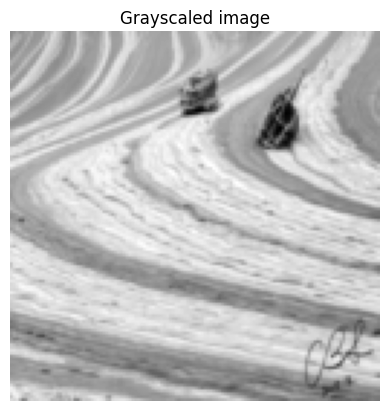

(128, 128) (128, 128) (128, 128)


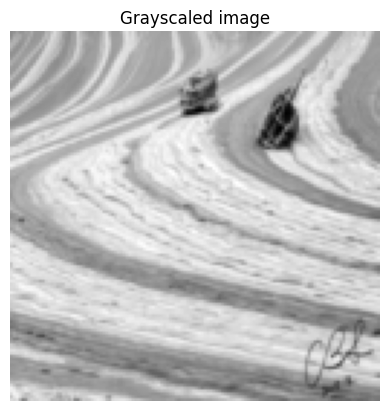

In [16]:
#test haar transform with resized 128 * 128 image
haar = HaarTransform("./Boneyard_IMG_5341.jpg")
haar.resize((128, 128))
haar.image_grayscaled.shape
haar.imshow(False)
haar.haar_transform(128)
haar.imshow(False)



In [30]:
for i in range(129):
    print(i, i & (i - 1) == 0 and i >=0)

0 True
1 True
2 True
3 False
4 True
5 False
6 False
7 False
8 True
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 True
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 True
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False
60 False
61 False
62 False
63 False
64 True
65 False
66 False
67 False
68 False
69 False
70 False
71 False
72 False
73 False
74 False
75 False
76 False
77 False
78 False
79 False
80 False
81 False
82 False
83 False
84 False
85 False
86 False
87 False
88 False
89 False
90 False
91 False
92 False
93 False
94 False
95 False
96 False
97 False
98 False
99 False
100 False
101 False
102 False
103 False
104 False
105 False
106 False
107 False
108 False
109 False
110 False
111 Fals

In [8]:
a = None

if not a :
    print("HI")

HI


In [ ]:
def 